# Wine Quality
The idea is to predict the quality of the red and white wine from a serie of different features.
We are going to work trough it as a clasification problem, and we are going to try 2 different algorithms with sklearn: k-nearest neighbor and logistic regression.

## Brief description of the dataset
There are almost 1600 instances in the dataset, 11 features and the target value. The target going from 3 to 8 both included, discrete values. Some can considerate to bin the data and say 3 to 6 = Bad Wine, >6 = Good wine. We are going to try it as our second approach.

#### Credits: @Luxenburgo who provides the dataset and created the group.

## Load the data.

At beginning we use numpy and pandas to do the preliminar work with the data. We are going to check is we can work with the complete dataset, let's see what are the results without any featuring.

In [67]:
# Import necesary packages.
import pandas as pd
import numpy as np

# Insert your path to your dataset here. Rememeber that this model is for red wine.
path = '..\dataset\winequality-red.csv'
data = pd.read_csv(path , delimiter= ';')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1:].values

In [68]:
print(data.shape, X.shape, y.shape)

(1599, 12) (1599, 11) (1599, 1)


With the code provided by @Luxemburgo we have succesfully split the data into target and features.

In [69]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

We are going to try to predict quality based on the physicochemical tests.

## Distribution of the target value
We are going to use matplotlib to see the distribution of our target value.

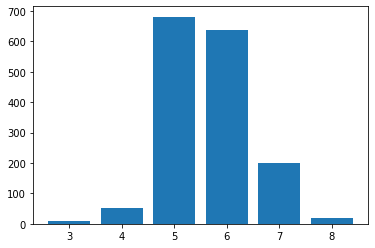

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

# Group by quantity and count the instances
quantity = data.groupby('quality').size().values
# Save the labels in order to plot the result
labels = data.groupby('quality').size().index

# Graph the chart
plt.bar(labels, quantity)
plt.xticks(labels)
plt.show()

We can achieve the exact same result by simply doing

In [71]:
data.groupby('quality').size()

quality
3     10
4     53
5    681
6    638
7    199
8     18
dtype: int64

So, at this moment it is clear that the data is centered mostly beetwen 2 values: 5 and 6. Next, we are going to use a box plot matrix to explore the data a little bit further.

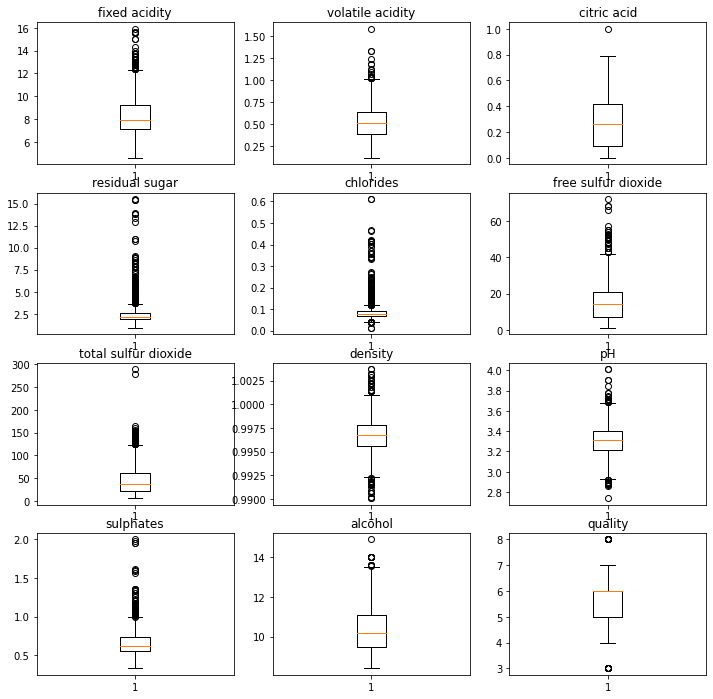

In [72]:
# Get the names of the columns from data in order to loop over it
column_names = []
for name in data.columns:
    column_names.append(name)

# Create the graph
fig, axs = plt.subplots(4, 3, figsize = (12,12))
# Iterate over the subplots to plot the variables.
counter = 0
for i in range(4):
    for j in range(3):
        axs[i,j].set_title(column_names[counter])
        axs[i,j].boxplot(data[column_names[counter]])
        counter += 1

Analizing the graphs from above we notice that there seems to be 3 variables with a bunch of outliers: residual_sugar, chlorides and sulphates. That could be a problem because it adds a lot of noise to our model. Next, let's plot the pearson correlation and see the correlation beetwen the variables.

## Pearson Correlation
At beginning we are going to use the Pearson correlation to have a better understanding of what is ralated to what in our dataset and see if we can get rid of the features that arent related to our target variable. For more information about Pearson correlation: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

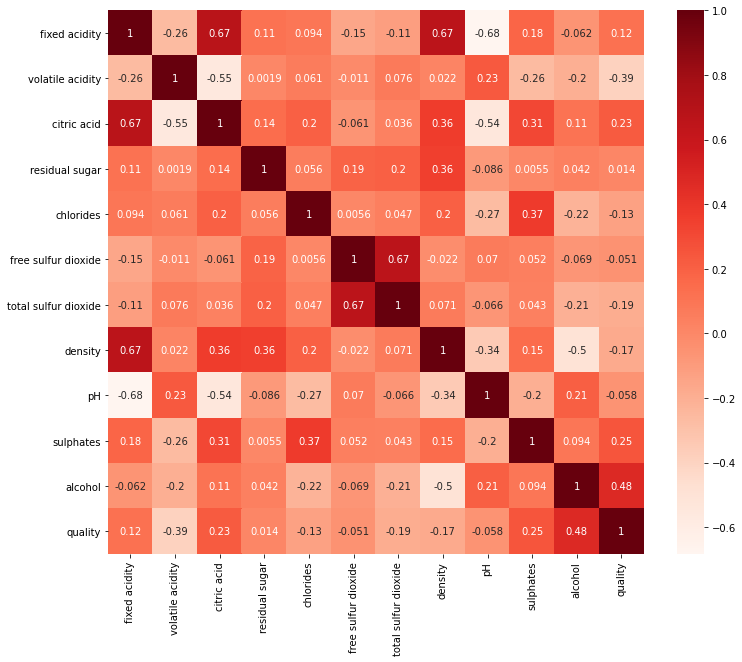

In [73]:
# Import necesary libraries
import seaborn as sns

# Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Pearson correlation goes from -1 to 1, being the extremes perfect correlations. With the graph it is clear that the features that explain better the differents qualities of the wine are "alcohol, sulphates and citric acid". 

Also, at first glance there seems to be correaltion beetwen fixed acidity and "citric acid, density and ph". If we are going to use regressions models, we assume that the features are independent so we are going to have to take care of this situation. Next, let's do some basic statistic to describe the data.

In [74]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We can see that the range of the variables differ and all of them mean different things, we are going to use some scaling.

# First model: KNN with the complete dataset.
First, we are going to try the model without doing any tunning or dimensionality reduction. And then, we are going to get rid of the features that we dont need.

In [75]:
# Import the necesary libraries.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Use a standard scaler. We applied fit_transform to the training dataset and the transform to the test in order to use the same mean and std.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
# Import the necesary libraries
from sklearn.neighbors import KNeighborsClassifier

# Initialize the class of the model. You can check the "weights" here, as a default KNN treat each point in the neighborhood as weighted equally.
# Check: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# We use 'distance' because it gives a better performance.

knn = KNeighborsClassifier(weights = 'distance')
# Fit the data.
knn.fit(X_train, y_train)

# Print the results.
print('Accuracy on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.64


## Results
Ok, so the model seems to overfit. We could manage trying to play with the different settings of the knn class, but it is going to be wiser to fix our training dataset, as we saw, there were some noise. So we are going to tray to get rid of that first. 

# Second Model: KNN with less features.

In [77]:
# First, let's just make a dataset with those variables.
X_pearson = data.loc[:, ['alcohol', 'citric acid', 'sulphates']]
y_pearson = data.loc[:, ['quality']]

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_trainp, X_testp, y_trainp, y_testp = train_test_split(X_pearson, y_pearson, random_state=0)

scaler = StandardScaler()
X_trainp = scaler.fit_transform(X_trainp)
X_testp = scaler.transform(X_testp)

In [79]:
# We have already imported the knn clasifier.

knn = KNeighborsClassifier(weights= 'distance')
knn.fit(X_trainp, y_trainp)

print('Accuracy on training set: {:.2f}'.format(knn.score(X_trainp, y_trainp)))
print('Accuracy on test set: {:.2f}'.format(knn.score(X_testp, y_testp)))

Accuracy on training set: 0.99
Accuracy on test set: 0.65


So, we just got 1% better with this model. We can try to get rid of the outliers in the data that we are using, but there is no going to be an important improvement in the stimation. As was suggested in discord, we are going to try to bin the data. 3-6 Bad Quality, 7-8 Good Quality

# Bin the data

In [80]:
# Create a new column in the target DF.
y_pearson['new_target'] = np.select((y_pearson['quality'] <= 6, y_pearson['quality'] > 6), (0, 1))

In [81]:
y_pearson.groupby('new_target').size()

new_target
0    1382
1     217
dtype: int64

In [82]:
# We have already imported the knn clasifier and the libraries

X_trainp2, X_testp2, y_trainp2, y_testp2 = train_test_split(X_pearson, y_pearson['new_target'], random_state=0)

knn = KNeighborsClassifier(weights='distance')
knn.fit(X_trainp2, y_trainp2)

print('Accuracy on training set: {:.2f}'.format(knn.score(X_trainp2, y_trainp2)))
print('Accuracy on test set: {:.2f}'.format(knn.score(X_testp2, y_testp2)))

Accuracy on training set: 1.00
Accuracy on test set: 0.88


Let's try a Logistic Regresion.

In [83]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(X_trainp2, y_trainp2)

print('Accuracy on training set: {:.2f}'.format(log.score(X_trainp2, y_trainp2)))
print('Accuracy on test set: {:.2f}'.format(log.score(X_testp2, y_testp2)))

Accuracy on training set: 0.87
Accuracy on test set: 0.90


# Conclusion
Bining the data was a good decision. We couldnt predict wether the quality of the wine was of a particular score, but we can predict wether it is good or bad quality wine.

The reason that we couldnt predict the quality is because the information we have is not related enough with the phenomenum we are trying to predict. A good idea might to be to investigate if there are other important variables, some hints are: the quality and variety of the seed, the region that the wine was produce, maybe the producer as well, the aging time as well.

Further analysis is needed but transforming the question in something solvable was a good idea.